# Applying Ice Flow Perturbation Analysis to Isunguata Sermia, Greenland

In [1]:
 # You will need the following packages to run the code in this notebook
import geopandas as gpd
from osgeo import gdal
import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata
from sklearn import linear_model
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import itertools

from scipy.fft import fft2, ifft2
from inversion_module_v2 import calcLM_KK, filter

In [ ]:
# Import a whole load of useful packages
import numpy as np 
import pandas as pd
from netCDF4 import Dataset
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os.path
import re
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import glob
import itertools
from matplotlib.pyplot import cm
from matplotlib.ticker import LogFormatter
import matplotlib.colors
from scipy.interpolate import griddata 
from scipy.fft import fft, ifft, fft2, ifft2, fftshift, fftfreq
from scipy import signal
from scipy.optimize import minimize
from inversion_module_v2 import calcLM_KK, filter
from inversion_module import bed_conditions_frot, bed_conditions_drot, smooth_arr
from inversion_module import terminal_inversion
from file_processing import Write_to_nc
from shapely.geometry import Point, LineString, Polygon

from sklearn import linear_model

# note that the transfer function module is called later but is also needed 

In [2]:
# Files that you will need to run this notebook
filepath_bedmach = "../Data/BedMachineGreenland-v5.nc"                                     # Bedmachine Greenland v5
filepath_arcticdem = '../Helen_isurf_velS/isunguatasermia_arcticdem_mosaic_100m_v2.tif'    # ArcticDEM .tif
filepath_UVEL = '../Helen_isurf_velS/U_avg_100m_2022-1-1_2024-1-1_img_rep_20-400days.tif'  # U velocity .tif
filepath_VVEL = '../Helen_isurf_velS/V_avg_100m_2022-1-1_2024-1-1_img_rep_20-400days.tif'  # V velocity .tif

# Load in useful files for plotting
GrLaGrLi = gpd.read_file("../Data/Greenland_coast.shp")                                    # Greenland coastline .shp

In [3]:
# Define some useful functions

def GR_smooth_data_load(bounds, filepath_bedmach):
    """ This function loads in the measures ice velocity datasets and the bedmachine greenland datasets
        within a specified region given by the variable bounds. 
        bounds = [xmin, xmax, ymin, ymax] in polar stereographic coordinates. """
    # Load in the bedmachine greenland data 
    filepath2 = filepath_bedmach
    fh2 = Dataset(filepath2, 'r', format='NETCDF4');
    Xnew = fh2.variables['x'][:]
    Ynew = fh2.variables['y'][:]
    xl2 = next(x for x, val in enumerate(Xnew) if val >= bounds[0]) # X in ascending order
    xh2 = next(x for x, val in enumerate(Xnew) if val >= bounds[1])
    yl2 = next(x for x, val in enumerate(Ynew) if val <= bounds[2])  # Y in descending order
    yh2 = next(x for x, val in enumerate(Ynew) if val <= bounds[3])  
    X_bedmach = Xnew[xl2:xh2]
    Y_bedmach = Ynew[yh2:yl2]
    X_bedmach, Y_bedmach = np.meshgrid(X_bedmach, Y_bedmach)
    SURF = fh2.variables['surface'][yh2:yl2,xl2:xh2]
    bed = fh2.variables['bed'][yh2:yl2,xl2:xh2]
    thick = fh2.variables['thickness'][yh2:yl2,xl2:xh2]
    errbed = fh2.variables['thickness'][yh2:yl2,xl2:xh2]
    source = fh2.variables['thickness'][yh2:yl2,xl2:xh2]
    fh2.close()
    return X_bedmach, Y_bedmach, SURF, thick, bed, errbed, source 

def IFPA(X_coord, Y_coord, ArcticDEM2, Uvel, Vvel, X_bedmach, Y_bedmach, bed, thick, bounds):
    """ This function takes in the surface elevation and velocity data, as well as ice thickness
        measurements from Bedmachine Greenland, and outouts the expected variations to the long 
        wavelength topography in the bed. 
        bounds = [xmin, xmax, ymin, ymax] in polar stereographic coordinates. """
    # Trim the ice surface elevation and velocity datasets to the region of interest
    xl = next(x for x, val in enumerate(X_coord[0,:]) if val >= bounds[0]) # X in ascending order
    xh = next(x for x, val in enumerate(X_coord[0,:]) if val >= bounds[1])
    yl = next(x for x, val in enumerate(Y_coord[:,0]) if val <= bounds[2])  # Y in descending order
    yh = next(x for x, val in enumerate(Y_coord[:,0]) if val <= bounds[3])  
    X_small = X_coord[yh:yl, xl:xh]
    Y_small = Y_coord[yh:yl,xl:xh]
    S_small = ArcticDEM2[yh:yl, xl:xh]
    U_small = Uvel[yh:yl, xl:xh]
    V_small = Vvel[yh:yl, xl:xh]
    # Trim the ice thickness from Bedmachine Greenland to the region of interest
    xl = next(x for x, val in enumerate(X_bedmach[0,:]) if val >= bounds[0]) # X in ascending order
    xh = next(x for x, val in enumerate(X_bedmach[0,:]) if val >= bounds[1])
    yl = next(x for x, val in enumerate(Y_bedmach[:,0]) if val <= bounds[2])  # Y in descending order
    yh = next(x for x, val in enumerate(Y_bedmach[:,0]) if val <= bounds[3])  
    T_small = thick[yh:yl, xl:xh]
    BMach_small = bed[yh:yl, xl:xh]
    Xbm_small = X_bedmach[yh:yl, xl:xh]
    Ybm_small = Y_bedmach[yh:yl, xl:xh]
    # Set some key variables (these should really be defined in the function but I am being lazy) 
    m = 1                    # Sliding law constant
    C = 50                   # Mean slipperiness
    p_b = -2                 # Filtering parameter
    p_c = -2                 # Filtering parameter
    erB = 1 * (10 **(-3))    # Weighting of elevation and velocity data sets
    erC = 1 * (10 **(-3))    # Weighting of elevation and velocity data sets
    trans_funcs = 2003       # Set which version of the transfer functions to use (2003 or 2008) 
    tapering = 0.1           # Fraction of edge to smooth for fourier transform
    CutB = 5                 # Angle to flow of features removed in inversion results
    CutC = 5                 # Angle to flow of features removed in inversion results
    wavcutB = 1              # Factor of h_bar, wavelength of features removed in inversion results
    wavcutC = 2              # Factor of h_bar, wavelength of features removed in inversion results
    h_bar = np.nanmean(T_small) # Mean ice thickness (Set here from Bedmachine Greenland)
    u_bar = np.nanmean(np.sqrt(V_small**2 + U_small**2)) # Mean ice speed
    print("In this region the average ice thickness (h_bar) is {:.0f} m".format(h_bar))
    print("In this region the average ice speed (u_bar) is {:.0f} m/s".format(u_bar))
    if trans_funcs == 2008:
        from transferfuncs2008 import Tsb, Tub, Tvb, Tsc, Tuc, Tvc
    elif trans_funcs == 2003:
        from transferfuncs2003 import Tsb, Tub, Tvb, Tsc, Tuc, Tvc
    else:
        print('Error in transfer functions requested in bed_conditions_clean')
    ## Calculating the angle of slope and correcting the ice surface for this region of interest
    # To calculate the mean slope across the patch
    xs = np.ndarray.flatten(X_small[::,::])
    ys = np.ndarray.flatten(Y_small[::,::])
    zs = np.ndarray.flatten(S_small[::, ::])
    # Using matrix algebra to fit a plane to the 3D data
    tmp_A = []
    tmp_b = []
    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    fit = (A.T * A).I * A.T * b
    alpha_s = np.array((fit[0]**2 + fit[1] **2)/ (np.sqrt((fit[0]**2 + fit[1] **2))))
    angle = -(np.arctan2(fit[1],fit[0]) *180/np.pi)
    #print(angle)
    # Remove the surface slope from the surface data
    SLOPE_its = X_small * np.array(fit[0]) + Y_small * np.array(fit[1]) + np.array(fit[2])
    SURF_interp = S_small - SLOPE_its
    # Recalculate the velocity fields so that VX is the speed in the direction of flow 
    ice_speed = np.sqrt(U_small**2 + V_small**2)
    theta = np.arctan2(V_small, U_small)
    theta[theta < 0] = theta[theta < 0] + np.pi * 2
    ice_direct = np.mean(theta) * 180/np.pi
    VX_rot =  ice_speed * np.cos(theta-(np.array(ice_direct) * np.pi/180))
    VY_rot =  ice_speed * np.sin(theta-(np.array(ice_direct) * np.pi/180))
    # Create a tapering grid to smooth for the fourier transform
    spacing = np.abs(X_small[0,0]-X_small[0,1])
    edge_smoothing = ((np.nanmax(Y_small) - np.nanmin(Y_coord)) * tapering)
    edge_w = int(edge_smoothing/spacing)
    tap1 = np.linspace(0,1,edge_w)
    tap2x = np.ones(X_small.shape[1]- 2* edge_w)
    tap2y = np.ones(X_small.shape[0]- 2* edge_w)
    tap3 = np.flip(tap1)
    tapx = np.hstack([tap1,tap2x,tap3])
    tapy = np.hstack([tap1,tap2y,tap3])
    X1, Y1 = np.meshgrid(tapx,tapy)
    z = X1*Y1
    # Remove means and prepare for tapering
    S_corr = SURF_interp
    S_corr = S_corr - np.mean(S_corr)
    U_corr = VX_rot - np.mean(VX_rot)
    V_corr = VY_rot - np.mean(VY_rot)
    # Apply tapering and remove means again
    # Non-dimensionalise 
    S_4inv = S_corr / h_bar * z
    S_4inv = S_4inv - np.mean(S_4inv)
    U_4inv = U_corr / u_bar * z
    U_4inv = U_4inv - np.mean(U_4inv)
    V_4inv = V_corr / u_bar * z
    V_4inv = V_4inv - np.mean(V_4inv)
    # Fourier transform
    S_ft = fft2(S_4inv)
    U_ft = fft2(U_4inv)
    V_ft = fft2(V_4inv)
    # Create the arrays of k and l for the tranfer functions 
    ar1 = np.fft.fftfreq(X_small.shape[1], spacing/h_bar)
    ar2 = np.fft.fftfreq(X_small.shape[0], spacing/h_bar)
    k,l = np.meshgrid(ar1,ar2)
    angle2 = angle
    #angle2 = ice_direct
    j = np.sqrt( k **2 + l **2)
    theta = np.arctan2(l,k) * (180/np.pi)
    # Recalculate the transfer functions in the right direction
    wave_angle_to_slope = theta - np.array(angle2) 
    k_prime = j * np.cos(wave_angle_to_slope * np.pi/180)
    l_prime = j * np.sin(wave_angle_to_slope * np.pi/180)
    theta_prime = np.arctan2(l_prime,k_prime) * (180/np.pi)
    # Smoothing the input data and weighting it appropriately
    S_filt_ft_b, S_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, m, C, S_ft, trans_funcs)
    U_filt_ft_b, U_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, m, C, U_ft, trans_funcs)
    V_filt_ft_b, V_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, m, C, V_ft, trans_funcs)
    S_filt_ft_c, S_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, m, C, S_ft, trans_funcs)
    U_filt_ft_c, U_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, m, C, U_ft, trans_funcs)
    V_filt_ft_c, V_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, m, C, V_ft, trans_funcs)
    # Calculating the inverse transfer functions
    TBS, TBU, TBV = calcLM_KK(erB, k_prime, l_prime, alpha_s, m, C, trans_funcs, rLM_KK = False, BtrueCfalse = True)
    TCS, TCU, TCV = calcLM_KK(erC, k_prime, l_prime, alpha_s, m, C, trans_funcs, rLM_KK = False, BtrueCfalse = False)
    # Calculating the bed conditions, inverse fourier transform and rescaling
    B_ft = TBV * V_filt_ft_b + TBU * U_filt_ft_b + TBS * S_filt_ft_b
    C_ft = TCV * V_filt_ft_c + TCU * U_filt_ft_c + TCS * S_filt_ft_c
    B_ft[np.isnan(B_ft) ==True ] = 0
    C_ft[np.isnan(C_ft) ==True ] = 0
    # Removing features with problematic wavenumber combinations
    CutC = CutC * np.pi/180
    maskCutC = (np.abs(theta) < (CutC + np.pi/2)) & (np.abs(theta) > (np.pi/2 - CutC))
    maskCutC2 = (np.abs(theta) < CutC) + (np.abs(theta) > (np.pi - CutC))
    C_ft[maskCutC + maskCutC2] = 0
    maskwavcutC = ((1/j)*h_bar) <  wavcutC * h_bar
    C_ft[maskwavcutC] = 0
    theta = np.arctan2(l_prime,k_prime)
    theta2 = theta * (-np.cos((theta/CutB) * np.pi) + 1)/2
    CutB = CutB * np.pi/180
    mask = (np.abs(theta) < (CutB + np.pi/2)) & (np.abs(theta) > (np.pi/2 - CutB))
    maskand = (np.abs(theta) < CutB) + (np.abs(theta) > (np.pi - CutB))
    B_ft[mask] = B_ft[mask] * theta2[mask]
    # Redimensionalising
    B_ift = (ifft2(B_ft) * h_bar) #+ SLOPE_its - (h_bar)
    C_ift = ifft2(C_ft) * C + C
    # Interpolate the bedmachine bed data (150m grid) onto the ArcticDEM coordinates (100m grid)
    X_flat = np.ndarray.flatten(X_bedmach)
    Y_flat = np.ndarray.flatten(Y_bedmach)
    S_flat = np.ndarray.flatten(bed) 
    bed_interp = griddata((X_flat, Y_flat), S_flat, (X_small, Y_small), method = 'cubic')
    return B_ift, bed_interp, X_small, Y_small, S_small, U_small, V_small, SURF_interp, VX_rot, VY_rot, ice_direct, S_4inv, U_4inv, V_4inv

### Ice surface conditions and bed conditions at Isunguata Sermia

For some reason the Arctic DEM file provided has elevation values ranging from a minimum of 335815 m elevation to a maximum of 1772324 m of elevation. I have used the surface elevation field of the Bedmachine Greenland v5 dataset here to correct this, but if you have a different version of the Artic DEM dataset with better values feel free to use those. I don't expect it to make much difference to the final results though.

In [4]:
# Load in the ARCTIC DEM MOSAIC 
step1 = gdal.Open(filepath_arcticdem, gdal.GA_ReadOnly)
GT_input = step1.GetGeoTransform()
step2 = step1.GetRasterBand(1)
ArcticDEM = step2.ReadAsArray()
step1 = None
print("Maximum value of Arctic DEM dataset: {:.0f} m".format(np.max(ArcticDEM)))
print("Minimum value of Arctic DEM dataset: {:.0f} m".format(np.min(ArcticDEM)))
print("This looks suspicious")

Maximum value of Arctic DEM dataset: 1772324 m
Minimum value of Arctic DEM dataset: 335815 m
This looks suspicious


In [5]:
# Create X coordinates for the Arctic DEM data 
xmin, xstep, _, ymin, _, ystep  = GT_input
ycount, xcount = ArcticDEM.shape
Xcoord = np.arange(xmin, xmin + xstep * (xcount), xstep)
Ycoord = np.arange(ymin, ymin + ystep * (ycount), ystep)
X_coord, Y_coord = np.meshgrid(Xcoord, Ycoord)

In [6]:
# Load in some surface and bed data from Measures and Bedmachine Greenland
bounds = [np.min(X_coord), np.max(X_coord), np.min(Y_coord), np.max(Y_coord)]
X_bedmach, Y_bedmach, SURF, thick, bed, errbed, source = \
        GR_smooth_data_load(bounds, filepath_bedmach)
# Set the ice thickness to be nan where there is no ice 
thick[thick <= 0] = np.nan
print("Maximum value of Bedmachine surface dataset: {:.1f} m".format(np.max(SURF)))
print("Minimum value of Bedmachine surface dataset: {:.1f} m".format(np.min(SURF)))
print("This looks more like what we expect")

Maximum value of Bedmachine surface dataset: 668.0 m
Minimum value of Bedmachine surface dataset: 97.3 m
This looks more like what we expect


In [7]:
# Interpolate the bedmachine surface data (150m grid) onto the ArcticDEM coordinates (100m grid)
X_flat = np.ndarray.flatten(X_bedmach)
Y_flat = np.ndarray.flatten(Y_bedmach)
S_flat = np.ndarray.flatten(SURF) 
S_interp = griddata((X_flat, Y_flat), S_flat, (X_coord, Y_coord), method = 'cubic')

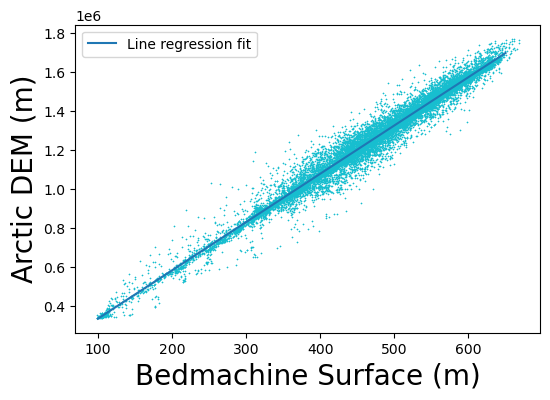

In [8]:
# Fit a linear regression model to convert ArcticDEM back to the height it should be
regr = linear_model.LinearRegression()
mask = ~np.isnan(S_interp)
regr.fit(S_interp[mask].reshape(-1,1), ArcticDEM[mask])
fig, ax = plt.subplots(1,1,figsize = (6,4))
plt.scatter(S_interp[mask].reshape(-1,1), ArcticDEM[mask], s = 0.01, color = 'C9', marker = '*')
line_x = np.arange(100,700, 50)
line_y = regr.coef_ * line_x + regr.intercept_
plt.plot(line_x, line_y, label = 'Line regression fit')
plt.xlabel('Bedmachine Surface (m)', fontsize = 20)
plt.ylabel('Arctic DEM (m)', fontsize = 20);
plt.legend()
# Convert ArcticDEM
ArcticDEM2 = (ArcticDEM - regr.intercept_)/regr.coef_

In [9]:
# Load in the velocity data
step1 = gdal.Open(filepath_UVEL, gdal.GA_ReadOnly)
GT_input = step1.GetGeoTransform()
step2 = step1.GetRasterBand(1)
Speed = step2.ReadAsArray()
Speed[Speed == -9999] = np.nan
Uvel = Speed
step1 = None
step1 = gdal.Open(filepath_VVEL, gdal.GA_ReadOnly)
GT_input = step1.GetGeoTransform()
step2 = step1.GetRasterBand(1)
Speed = step2.ReadAsArray()
Speed[Speed == -9999] = np.nan
Vvel = Speed
step1 = None

In [10]:
# Create some regional outlines for areas of possible interest
poly_data = Polygon([(np.min(X_coord), np.min(Y_coord)), (np.min(X_coord), np.max(Y_coord)), \
                (np.max(X_coord), np.max(Y_coord)), (np.max(X_coord), np.min(Y_coord))])

x_shift = 10500 
y_shift = 2200
x_width = 5000
y_width = 5500
poly_data2 = Polygon([(np.min(X_coord) + x_shift, np.min(Y_coord) + y_shift), 
                      (np.min(X_coord) + x_shift + x_width, np.min(Y_coord) + y_shift), 
                      (np.min(X_coord) + x_shift + x_width, np.min(Y_coord) + y_shift + y_width), 
                      (np.min(X_coord) + x_shift, np.min(Y_coord) + y_shift + y_width)])
boundsA = [np.min(X_coord) + x_shift, np.min(X_coord) + x_shift + x_width, \
          np.min(Y_coord) + y_shift, np.min(Y_coord) + y_shift + y_width]

x_shift = 6500 
y_shift = 2500
x_width = 4000
y_width = 4000
poly_data3 = Polygon([(np.min(X_coord) + x_shift, np.min(Y_coord) + y_shift), 
                      (np.min(X_coord) + x_shift + x_width, np.min(Y_coord) + y_shift), 
                      (np.min(X_coord) + x_shift + x_width, np.min(Y_coord) + y_shift + y_width), 
                      (np.min(X_coord) + x_shift, np.min(Y_coord) + y_shift + y_width)])
boundsB = [np.min(X_coord) + x_shift, np.min(X_coord) + x_shift + x_width, \
          np.min(Y_coord) + y_shift, np.min(Y_coord) + y_shift + y_width]

x_shift = 8500 
y_shift = 2500
x_width = 4000
y_width = 4000
poly_data4 = Polygon([(np.min(X_coord) + x_shift, np.min(Y_coord) + y_shift), 
                      (np.min(X_coord) + x_shift + x_width, np.min(Y_coord) + y_shift), 
                      (np.min(X_coord) + x_shift + x_width, np.min(Y_coord) + y_shift + y_width), 
                      (np.min(X_coord) + x_shift, np.min(Y_coord) + y_shift + y_width)])
boundsC = [np.min(X_coord) + x_shift, np.min(X_coord) + x_shift + x_width, \
          np.min(Y_coord) + y_shift, np.min(Y_coord) + y_shift + y_width]

/var/folders/vv/dwc29y01037580c3y3z84tw40000gp/T/ipykernel_51257/649137646.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im[i][j])
/var/folders/vv/dwc29y01037580c3y3z84tw40000gp/T/ipykernel_51257/649137646.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im[i][j])
/var/folders/vv/dwc29y01037580c3y3z84tw40000gp/T/ipykernel_51257/649137646.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im[i][j])
/var/folders/vv/dwc29y01037580c3y3z84tw40000gp/T/ipykernel

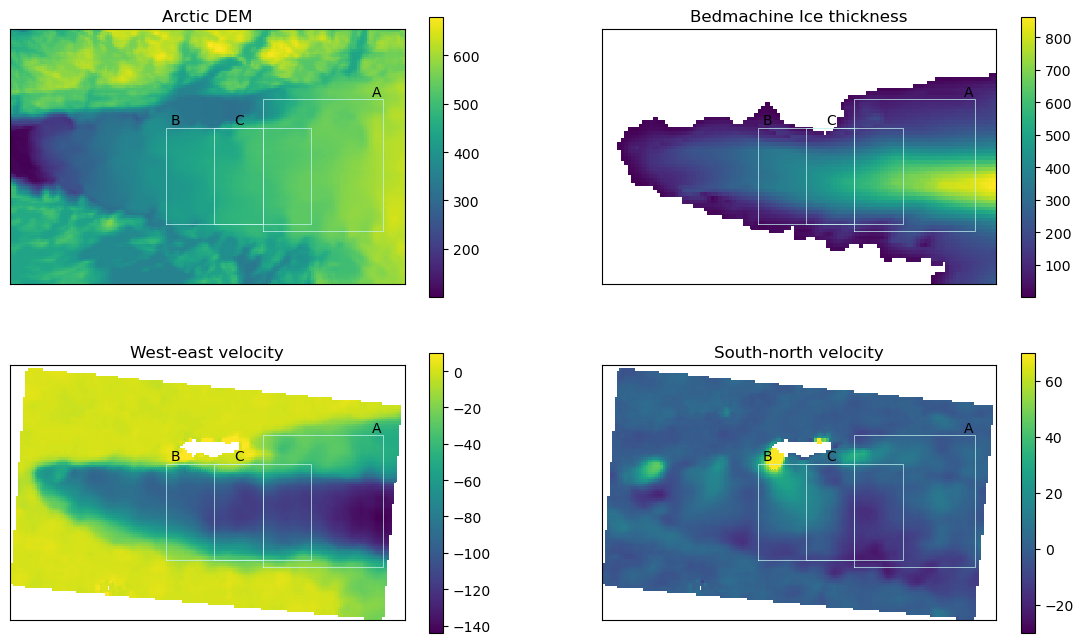

In [11]:
# Plot the data to get an overview of the regional conditions
fig, ax = plt.subplots(2,2, figsize = (14,8))
im = [[[],[]],[[],[]]]
titles = [['Arctic DEM','Bedmachine Ice thickness'],['West-east velocity','South-north velocity']]
im[0][0] = ax[0,0].pcolor(X_coord, Y_coord, ArcticDEM2, shading = 'auto')
im[0][1] = ax[0,1].pcolor(X_bedmach, Y_bedmach, thick, shading = 'auto')
im[1][0] = ax[1,0].pcolor(X_coord, Y_coord, Uvel, shading = 'auto')
im[1][1] = ax[1,1].pcolor(X_coord, Y_coord, Vvel, shading = 'auto')
for i,j in itertools.product(range(2), range(2)):
    plt.colorbar(im[i][j])
    GrLaGrLi.plot(ax = ax[i][j], facecolor = 'None', edgecolor='grey')
    ax[i][j].get_xaxis().set_ticks([]); ax[i][j].get_yaxis().set_ticks([]);
    ax[i][j].set_xlim(np.min(X_coord), np.max(X_coord))
    ax[i][j].set_ylim(np.min(Y_coord), np.max(Y_coord))
    ax[i][j].plot(*poly_data2.exterior.xy, color = '#c6f5f3', linewidth = 0.5)
    ax[i][j].plot(*poly_data3.exterior.xy, color = '#c6f5f3', linewidth = 0.5)
    ax[i][j].plot(*poly_data4.exterior.xy, color = '#c6f5f3', linewidth = 0.5)
    ax[i][j].set_title(titles[i][j])
    ax[i][j].annotate('A', xy = (2,1), xytext = (0.93, 0.74), xycoords = 'axes fraction', ha = 'center', color = 'k');
    ax[i][j].annotate('B', xy = (2,1), xytext = (0.42, 0.63), xycoords = 'axes fraction', ha = 'center', color = 'k');
    ax[i][j].annotate('C', xy = (2,1), xytext = (0.58, 0.63), xycoords = 'axes fraction', ha = 'center', color = 'k');
im[1][0].set_clim(None,10);
im[1][1].set_clim(-30,70);

# Applying Ice Flow Perturbation Analysis to the chosen regions

IFPA can resolve features with a horizontal wavelength similar to the ice thickness, which is variable at Isunguata Sermia but is approximately 400 m on average. I have therefore selected 3 rergions with dimensions 4 km by 4 km or greater to try applying IFPA to, so that each grid will cover multiple ice thicknesses horizontally. 

In [12]:
# Apply IFPA to the grid 
# The function which carries out this process is defined at the start of the notebook, 
# but I will illustate the stages of IFPA below.

B_ift_A, bed_interp_A, X_small, Y_small, S_small, U_small, V_small, SURF_interp, VX_rot, VY_rot, ice_direct, S_4inv, U_4inv, V_4inv = \
    IFPA(X_coord, Y_coord, ArcticDEM2, Uvel, Vvel, X_bedmach, Y_bedmach, bed, thick, boundsA)

In this region the average ice thickness (h_bar) is 377 m
In this region the average ice speed (u_bar) is 81 m/s


/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:22: RuntimeWarning: invalid value encountered in divide
  t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:47: RuntimeWarning: invalid value encountered in divide
  t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:74: RuntimeWarning: invalid value encountered in divide
  t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:91: RuntimeWarning: invalid value encountered in divide
  t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:114: RuntimeWarning: invalid value encountered in divide
  t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*t8*t9-(t11

### **Step 1:** Trim the data to the chosen region of interest, here region A

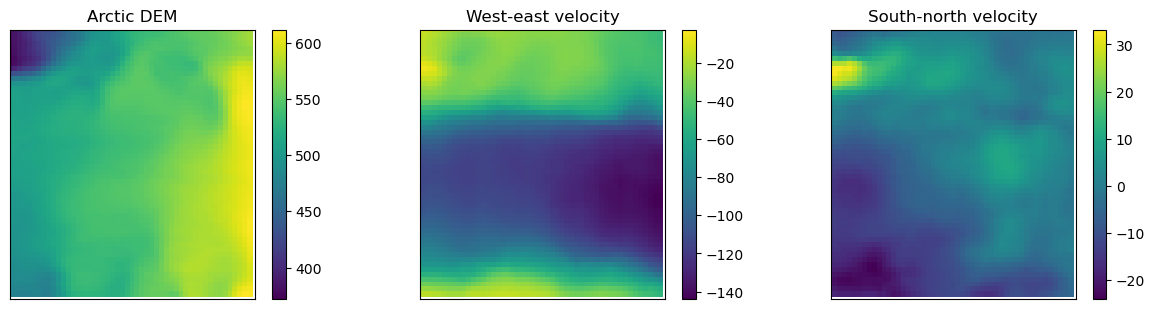

In [13]:
fig, ax = plt.subplots(1,3, figsize = (15,3.5))
im = [[],[],[]]
plots = [S_small, U_small, V_small]
titles = ['Arctic DEM', 'West-east velocity', 'South-north velocity']
for i in range(3):
    im[i] = ax[i].pcolor(X_small, Y_small, plots[i])
    plt.colorbar(im[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].set_title(titles[i])
    ax[i].set_xlim(boundsA[0], boundsA[1])
    ax[i].set_ylim(boundsA[2], boundsA[3])

### **Step 2:** Recalculation
We remove the mean slope from the ice surface elation, and recalculate the ice velocity so that it is aligned with the mean direction of ice flow (which should also correspond to the direction of slope of the surface DEM). In grid A (and all three grids in this notebook), the ice is flowing almost perfectly due west and therefore this recalculation is pretty much just a flipping of the signs of the velocities. 

Flow direction is: 181.7 degrees
(measured anticlockwise from east)


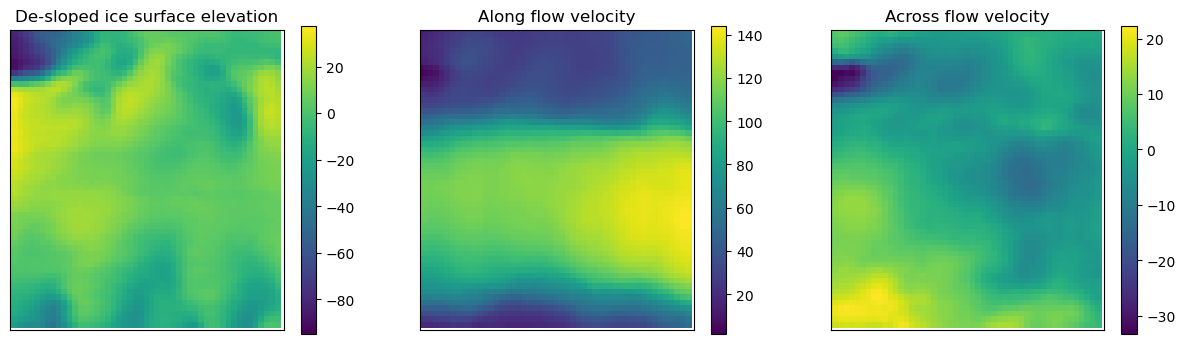

In [14]:
# Plot the data to have a look at it and make sure it looks like a sensible recalculation
fig, ax = plt.subplots(1,3, figsize = (15,4))
im0 = ax[1].pcolor(X_small, Y_small, VX_rot)
im1 = ax[2].pcolor(X_small, Y_small, VY_rot)
plt.colorbar(im0, ax = ax[1])
plt.colorbar(im1, ax = ax[2])
im0 = ax[0].pcolor(X_small, Y_small, SURF_interp)
plt.colorbar(im0, ax = ax[0])
titles = ['De-sloped ice surface elevation', 'Along flow velocity', 'Across flow velocity']
for i in range(3):
    ax[i].set_title(titles[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].set_title(titles[i])
    ax[i].set_xlim(boundsA[0], boundsA[1])
    ax[i].set_ylim(boundsA[2], boundsA[3])
print('Flow direction is: {:.1f} degrees'.format(ice_direct)) 
print('(measured anticlockwise from east)')

### **Step 3:** Non-dimensionalisation, and preparation for the Fourier transform

The three input fields (ice surface elevation, along-flow velocity and across-flow velocity) are prepared for the Fourier transform by removing the mean, applying a windowing function (here a simple trapezoid), and non-dimensionalising with respect to the reference length scale (the ice thickness) and the reference velocity scale (the mean ice-surface velocity). 

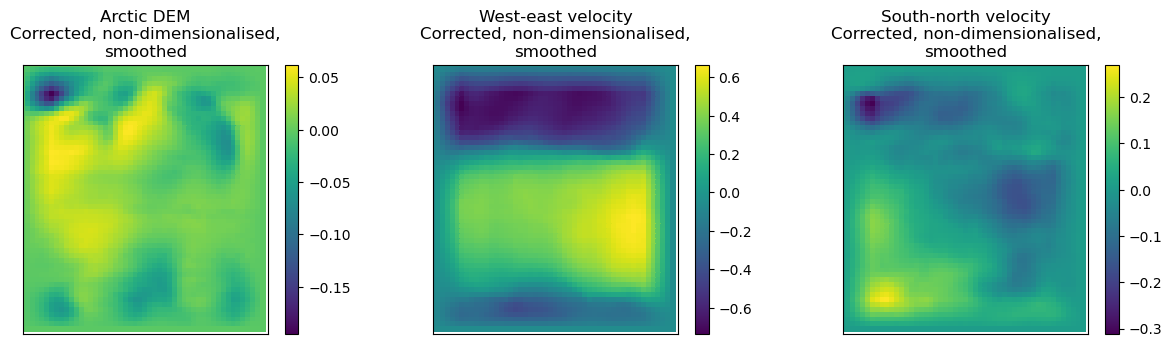

In [15]:
fig, ax = plt.subplots(1,3, figsize = (15,3.5))
im = [[],[],[]]
plots = [S_4inv, U_4inv, V_4inv]
titles = ['Arctic DEM', 'West-east velocity', 'South-north velocity']
for i in range(3):
    im[i] = ax[i].pcolor(X_small, Y_small, plots[i])
    plt.colorbar(im[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].set_title("{}\nCorrected, non-dimensionalised,\nsmoothed".format(titles[i]))
    ax[i].set_xlim(boundsA[0], boundsA[1])
    ax[i].set_ylim(boundsA[2], boundsA[3])
#im[1][0].set_clim(None,10)
#im[1][1].set_clim(-30,70)

### **Step 4:** Application of Ice Flow Perturbation Analysis 

These input fields are then Fourier transformed, so that the Fourier transfer functions (as defined by Gudmundsson, 2003) can be applied to them. The resultant bed topography undergoes an inverse Fourier transform and is re-dimensionalised, to give the perturbutions from the long wavelength state predicted by IFPA. 

Normally, we apply IFPA in the centre of the ice sheet, where flow can be safely assumed to be relatively close to planar flow in an inclined slab. However, for Isunguata Sermia, this assumption is obviously not suitable. There's probably better ways to approach this problem (See for example Ng et al. (2018,  https://doi.org/10.1029/2017JF004555)), but given that the Bedmachine topography in this region is pretty vague, I've just applied it as though it is the long wavelength state. 

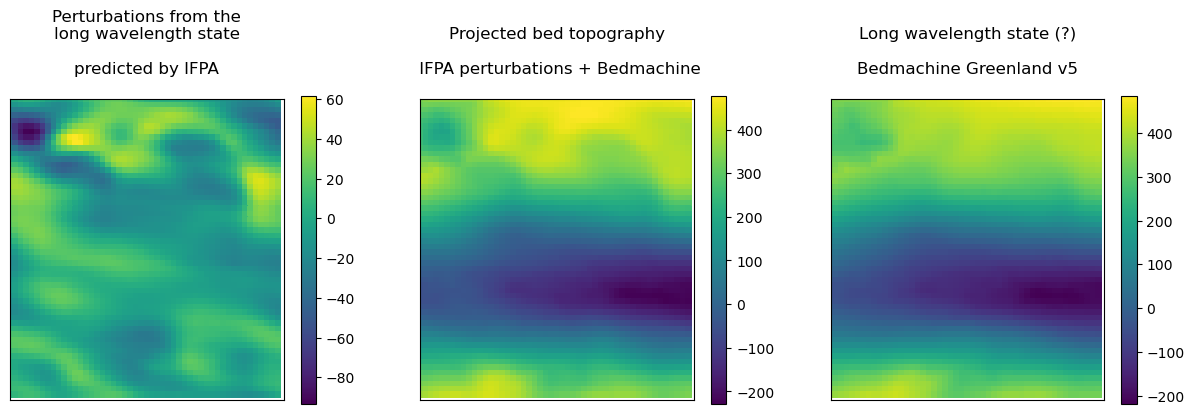

In [16]:
fig, ax = plt.subplots(1,3, figsize = (15,4))
im = [[],[],[]]
titles = ['Perturbations from the\nlong wavelength state\n\npredicted by IFPA\n',\
          'Projected bed topography\n\n IFPA perturbations + Bedmachine\n',\
          'Long wavelength state (?)\n\nBedmachine Greenland v5\n']
im[0] = ax[0].pcolor(X_small, Y_small, S_small)
im[0] = ax[0].pcolor(X_small, Y_small, B_ift_A.real)
im[1] = ax[1].pcolor(X_small, Y_small, bed_interp_A+ B_ift_A.real)
im[2] = ax[2].pcolor(X_small, Y_small, bed_interp_A)
for i in range(3):
    plt.colorbar(im[i], ax = ax[i])
    ax[i].set_title(titles[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].set_xlim(boundsA[0], boundsA[1])
    ax[i].set_ylim(boundsA[2], boundsA[3])

## Region B ##

In [17]:
# Apply IFPA to the grid 
B_ift_B, bed_interp_B, X_small_B, Y_small_B, S_small, U_small, V_small, SURF_interp, VX_rot, VY_rot, ice_direct, S_4inv, U_4inv, V_4inv = \
    IFPA(X_coord, Y_coord, ArcticDEM2, Uvel, Vvel, X_bedmach, Y_bedmach, bed, thick, boundsB)

In this region the average ice thickness (h_bar) is 290 m
In this region the average ice speed (u_bar) is 81 m/s


/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:22: RuntimeWarning: invalid value encountered in divide
  t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:47: RuntimeWarning: invalid value encountered in divide
  t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:74: RuntimeWarning: invalid value encountered in divide
  t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:91: RuntimeWarning: invalid value encountered in divide
  t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:114: RuntimeWarning: invalid value encountered in divide
  t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*t8*t9-(t11

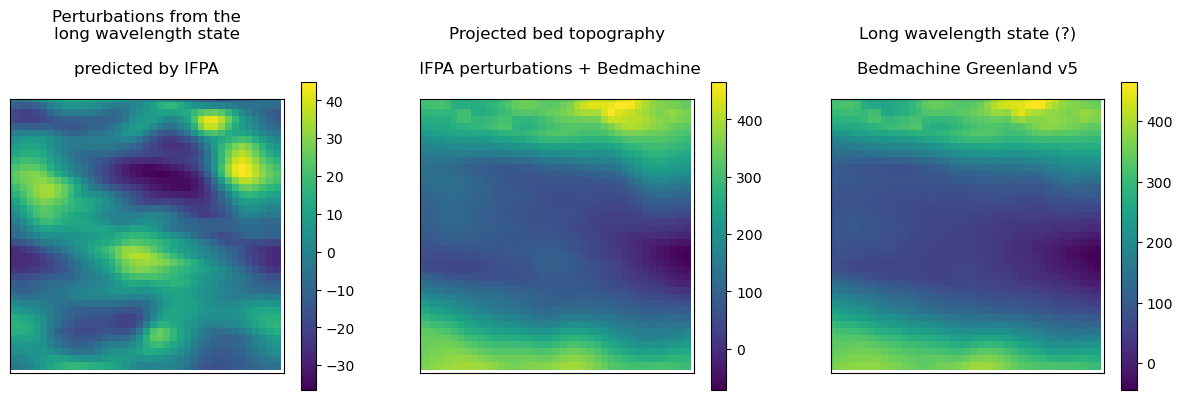

In [18]:
fig, ax = plt.subplots(1,3, figsize = (15,4))
im = [[],[],[]]
titles = ['Perturbations from the\nlong wavelength state\n\npredicted by IFPA\n',\
          'Projected bed topography\n\n IFPA perturbations + Bedmachine\n',\
          'Long wavelength state (?)\n\nBedmachine Greenland v5\n']
im[0] = ax[0].pcolor(X_small_B, Y_small_B, B_ift_B.real)
im[1] = ax[1].pcolor(X_small_B, Y_small_B, bed_interp_B+ B_ift_B.real)
im[2] = ax[2].pcolor(X_small_B, Y_small_B, bed_interp_B)
for i in range(3):
    plt.colorbar(im[i], ax = ax[i])
    ax[i].set_title(titles[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].set_xlim(boundsB[0], boundsB[1])
    ax[i].set_ylim(boundsB[2], boundsB[3])

## Region C ##

In [19]:
# Apply IFPA to the grid 
B_ift_C, bed_interp_C, X_small_C, Y_small_C, S_small, U_small, V_small, SURF_interp, VX_rot, VY_rot, ice_direct, S_4inv, U_4inv, V_4inv = \
    IFPA(X_coord, Y_coord, ArcticDEM2, Uvel, Vvel, X_bedmach, Y_bedmach, bed, thick, boundsC)

In this region the average ice thickness (h_bar) is 368 m
In this region the average ice speed (u_bar) is 88 m/s


/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:22: RuntimeWarning: invalid value encountered in divide
  t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:47: RuntimeWarning: invalid value encountered in divide
  t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:74: RuntimeWarning: invalid value encountered in divide
  t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:91: RuntimeWarning: invalid value encountered in divide
  t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
/Users/helen/Documents/IFPA /Inversion_code/transferfuncs2003.py:114: RuntimeWarning: invalid value encountered in divide
  t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*t8*t9-(t11

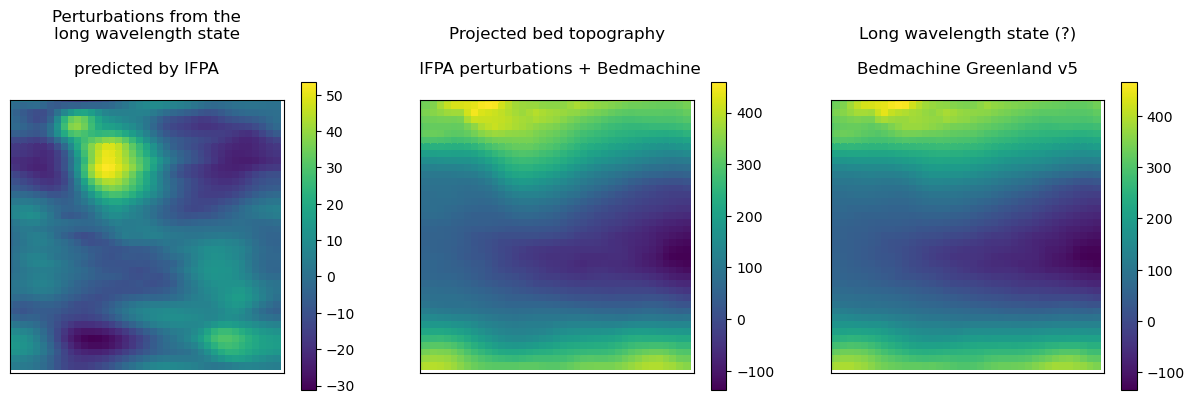

In [20]:
fig, ax = plt.subplots(1,3, figsize = (15,4))
im = [[],[],[]]
titles = ['Perturbations from the\nlong wavelength state\n\npredicted by IFPA\n',\
          'Projected bed topography\n\n IFPA perturbations + Bedmachine\n',\
          'Long wavelength state (?)\n\nBedmachine Greenland v5\n']
im[0] = ax[0].pcolor(X_small_C, Y_small_C, B_ift_C.real)
im[1] = ax[1].pcolor(X_small_C, Y_small_C, bed_interp_C+ B_ift_C.real)
im[2] = ax[2].pcolor(X_small_C, Y_small_C, bed_interp_C)
for i in range(3):
    plt.colorbar(im[i], ax = ax[i])
    ax[i].set_title(titles[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    ax[i].set_xlim(boundsC[0], boundsC[1])
    ax[i].set_ylim(boundsC[2], boundsC[3])

## Looking at all these regions together ##

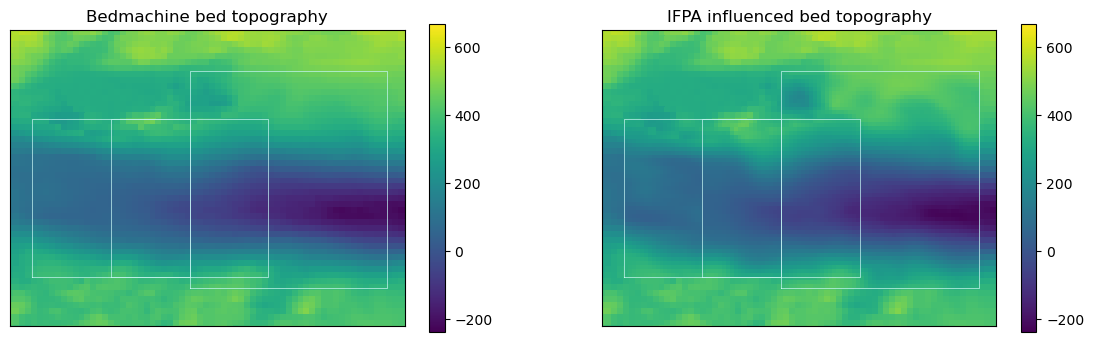

In [21]:
fig, ax = plt.subplots(1,2, figsize = (14,4))
titles = ['Bedmachine bed topography', 'IFPA influenced bed topography']
for i in range(2):
    im = ax[i].pcolor(X_bedmach, Y_bedmach, bed)
    plt.colorbar(im, ax = ax[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    #ax[i].set_xlim(np.min(X_coord), np.max(X_coord))
    #ax[i].set_ylim(np.min(Y_coord), np.max(Y_coord))
    ax[i].set_xlim(-0.228e6, -0.218e6)
    ax[i].set_ylim(-2.4965e6, -2.489e6)
    ax[i].plot(*poly_data2.exterior.xy, color = '#c6f5f3', linewidth = 0.5, zorder = 20)
    ax[i].plot(*poly_data3.exterior.xy, color = '#c6f5f3', linewidth = 0.5, zorder = 20)
    ax[i].plot(*poly_data4.exterior.xy, color = '#c6f5f3', linewidth = 0.5, zorder = 20)
    ax[i].set_title(titles[i])
im1 = ax[1].imshow(B_ift_A.real + bed_interp_A, extent = boundsA, zorder = 10)
im1.set_clim(np.min(bed), np.max(bed))
im1 = ax[1].imshow(B_ift_B.real + bed_interp_B, extent = boundsB, zorder = 10)
im1.set_clim(np.min(bed), np.max(bed))
im1 = ax[1].imshow(B_ift_C.real + bed_interp_C, extent = boundsC, zorder = 10)
im1.set_clim(np.min(bed), np.max(bed))

### Applying a cheeky exaggeration factor to make it easier to see where there might be features of interest ###

Because the perturbations suggested by IFPA are only 30 - 80 m in vertical amplitude, it can be hard to see them in comparison to the 1000 m of vertical elevation variability in the base bedmachine state. So I have been a bit cheeky here, and applied a 5* magnification factor to the perturbations from IFPA to make it easier to see the features which you might be interested. 

Note also that changing the order of the tiles (at the bottom of the box) will change the features that you can see slightly - generally IFPA is better further from the edge of the tile because of the windowing needed to carry out the Fourier transform. In the interior then we applied a smoothing factor to move between regions but I haven't done that here because it's a bit complicated for different sized regions and I didn't really think it was necessary.

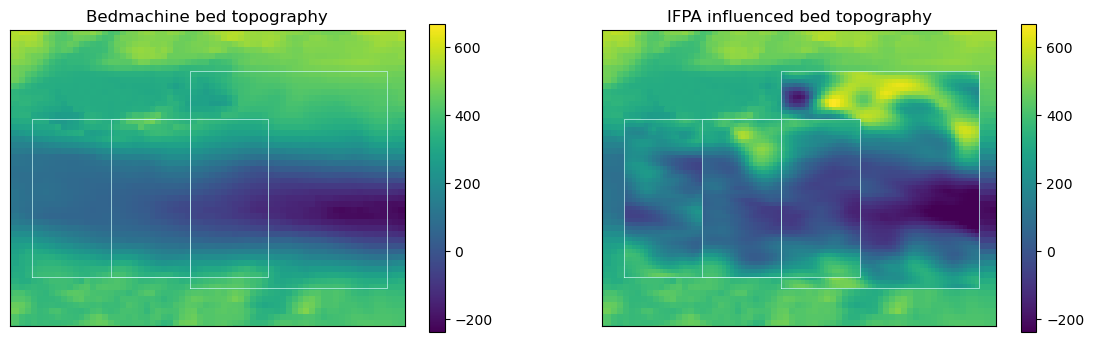

In [22]:
exag = 5

fig, ax = plt.subplots(1,2, figsize = (14,4))
titles = ['Bedmachine bed topography', 'IFPA influenced bed topography']
for i in range(2):
    im = ax[i].pcolor(X_bedmach, Y_bedmach, bed)
    plt.colorbar(im, ax = ax[i])
    GrLaGrLi.plot(ax = ax[i], facecolor = 'None', edgecolor='grey')
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);
    #ax[i].set_xlim(np.min(X_coord), np.max(X_coord))
    #ax[i].set_ylim(np.min(Y_coord), np.max(Y_coord))
    ax[i].set_xlim(-0.228e6, -0.218e6)
    ax[i].set_ylim(-2.4965e6, -2.489e6)
    ax[i].plot(*poly_data2.exterior.xy, color = '#c6f5f3', linewidth = 0.5, zorder = 20)
    ax[i].plot(*poly_data3.exterior.xy, color = '#c6f5f3', linewidth = 0.5, zorder = 20)
    ax[i].plot(*poly_data4.exterior.xy, color = '#c6f5f3', linewidth = 0.5, zorder = 20)
    ax[i].set_title(titles[i])
im1 = ax[1].imshow(B_ift_A.real*exag + bed_interp_A, extent = boundsA, zorder = 10)
im1.set_clim(np.min(bed), np.max(bed))
im1 = ax[1].imshow(B_ift_B.real*exag + bed_interp_B, extent = boundsB, zorder = 10)
im1.set_clim(np.min(bed), np.max(bed))
im1 = ax[1].imshow(B_ift_C.real*exag + bed_interp_C, extent = boundsC, zorder = 10)
im1.set_clim(np.min(bed), np.max(bed))